In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np

from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import compress


#### Load Recipes Data

In [2]:
recipes = json.load(open('./data/recipe_train.json'))

#### Convert recipe to text document

In [3]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [4]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

vectorizer = TfidfVectorizer(use_idf=True)
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [5]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    #one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

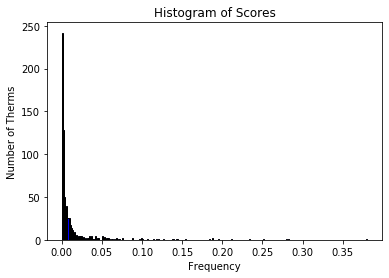

In [6]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Top 10 therms per cuisine

In [7]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    # print('-------------')
    # print(k)
    # print(scores_df.iloc[:10,:])


#### Load Baskets Market Data

In [8]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append(row)


#### Compute ngram for tf.idf top score 

In [9]:
top_scores_ngram = {}

for cuisine in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[cuisine]
    scores_df = scores_df[scores_df['score']>(statistics[cuisine][1]/4)]
    #scores_df = scores_df.iloc[:30,:]
    scores_df = scores_df.sort_values(by=['score'],ascending=False)
    
    ngram_scores = []
    for index, row in scores_df.iterrows():
        ngram = list(ngrams(row['term'], 3))
        score =  row['score']
        ngram_scores.append([ngram, score])
        
    top_scores_ngram[cuisine] = ngram_scores

#### Define the metric similarity

In [10]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

#### Compute Basket Scores
For each basket we iterate over all items and compute their similarities with the top 
terms in the cuisines docs

In [11]:
baskets_scores = []

for basket in baskets:
    similarities = {}
    for cuisine in top_scores_ngram:
        value = 0
        for item in basket:      
            item_ngram = list(ngrams(item, 3))
            for ngram_term, score in top_scores_ngram[cuisine]:
                sim = 1-jaccard_distance(item_ngram, ngram_term)
                if sim > 0:
                    value += sim * score
                    
        similarities[cuisine] = value    
    baskets_scores.append(similarities)
           
    # print('------------------')
    # print("basket: ", basket)
    # for k in similarities:
    #     print(k, similarities[k]) 

#### CLustering baskets
We now try to cluster the baskets, based on the scores that they 
obtained using frequent therms of recipes

In [12]:
baskets_scores_df = pd.DataFrame(baskets_scores)
X = StandardScaler().fit_transform(baskets_scores_df.to_numpy())

In [19]:
# DBSCAN 
[eps, min_samples] = [0.35, 50]
dbScan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
dbscan_labels = dbScan.labels_
print(set(dbscan_labels))
print([eps, min_samples])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
[0.35, 50]


In [20]:
# OPTICS
optics = OPTICS(min_samples=20, max_eps=0.35, xi=.05, min_cluster_size=.05)
optics.fit(X)
optics_labels = optics.labels_[optics.ordering_]
print(set(optics_labels))

{0, 1, 2, 3, 4, 5, 6, -1}


/home/nepotu/anaconda3/envs/dataMiningProject/lib/python3.7/site-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [15]:
# K-Means
kMeans = KMeans(n_clusters=10, random_state=0).fit(X)
kMeans_labels = kMeans.labels_
print(set(kMeans_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


#### Analysis of the method
First we are going to observe how big are our clusters

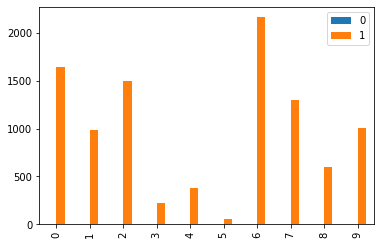

In [16]:
labels = dbscan_labels
cluster_sizes = []
for label in set(labels):
    cluster_sizes.append([label, len(baskets_scores_df[labels == label])])
pd.DataFrame(cluster_sizes).plot(kind='bar')

Now, we are going to calculate for each cluster, its overall score 
(by summing all scores of all items of that cluster) and select best 5

In [30]:
selected_basket_cluster = 0
selected_basket_scores = baskets_scores_df[labels == selected_basket_cluster]
aggregated_basket_cluster_score \
    = np.sum(selected_basket_scores, axis=0)\
    .sort_values(ascending=False)
selected_baskets = list(compress(baskets, labels == selected_basket_cluster))
selected_baskets = [' '.join(l) for l in selected_baskets]
aggregated_basket_cluster_score = aggregated_basket_cluster_score[0:50]
print(aggregated_basket_cluster_score)

mexican         18145.112068
french          16281.286698
greek           15333.697120
indian          14332.011358
japanese        14068.439684
thai            14019.739259
southern_us     13367.338830
irish           13341.927058
brazilian       13262.782595
russian         13195.199352
british         13012.422055
italian         12872.722542
spanish         12757.390082
filipino        12581.111610
vietnamese      11911.433929
chinese         11832.626127
korean          11496.712973
jamaican        10814.564341
cajun_creole     8546.829122
moroccan         8505.581745
dtype: float64


We calculate the most frequent therms (TF) of the cluster of baskets

In [31]:
countVectorizer = CountVectorizer()
wordCountVector = countVectorizer.fit_transform(selected_baskets)
vocabulary = pd.Series(countVectorizer.vocabulary_)
vocabulary = vocabulary[vocabulary > 0].sort_values(ascending=False)
print(vocabulary)

zwieback     174
yogurt       173
wine         172
whole        171
white        170
            ... 
bakery         5
bags           4
artif          3
articles       2
appetizer      1
Length: 174, dtype: int64


In [32]:
intersection_therms = {}
frequent_basket_cluster_terms = set(vocabulary)
for cuisine in aggregated_basket_cluster_score.index:
    frequent_cuisine_therms = set(docs_scores_dfs[cuisine]["term"][0:50])
    print(frequent_basket_cluster_terms.intersection(frequent_cuisine_therms))

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
